# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

In [1]:
from pathlib import Path
import pandas

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [2]:
# Add your imports here
import seaborn as sns
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

#### First look at data

In [3]:
"""
Dataframe Reperesentation
"""
data

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other,Legendary__other,Wins
39087,Karrablast,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,5.0,...,NaN,50.0,53.0,43.0,47.0,27.0,40.0,5.0,False,True
30893,NaN,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,1.0,...,NaN,65.0,64.0,NaN,49.0,41.0,39.0,5.0,False,True
45278,Mega Manectric,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,3.0,...,NaN,NaN,48.0,78.0,NaN,83.0,75.0,5.0,False,True
16398,Bouffalant,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,5.0,...,NaN,75.0,108.0,101.0,39.0,68.0,106.0,NaN,False,False
13653,Swablu,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,3.0,...,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,1.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,NaN,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,5.0,...,NaN,55.0,NaN,107.0,NaN,79.0,56.0,3.0,False,True
44732,Skrelp,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,6.0,...,NaN,65.0,59.0,70.0,79.0,79.0,33.0,1.0,False,False
38158,Florges,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,6.0,...,NaN,104.0,91.0,61.0,97.0,117.0,68.0,3.0,NaN,True
860,Pachirisu,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,4.0,...,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,4.0,NaN,True


In [4]:
"""
Dataframe info first observations:

    - Type 2 feature contains alot of nulls (Check what to do)
    - Generation is irrelevant info
    - Legendary is irrelevant info as it is inplicit on the stats
    - Name is irrelevant info
"""
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

In [5]:
"""
Impossible data found in minimums:
    There are some stats in neggative. Look for impossible values.
"""
data.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Generation__other
count,35994.000000,36103.000000,35966.000000,36080.000000,36018.000000,36028.000000,36007.000000,35895.000000,36005.000000,35984.000000,35904.000000,35995.000000,35956.000000,36014.000000
mean,69.771879,79.254023,74.663933,73.425139,72.465434,68.790441,3.333630,69.838418,79.254909,74.787961,73.168951,72.582525,68.781622,3.337702
std,26.610838,33.408366,32.402967,33.507089,28.982072,30.178166,1.656558,26.604671,33.160915,32.456015,33.486762,28.986777,29.998563,1.654265
min,1.000000,-4.000000,-7.000000,2.000000,8.000000,-4.000000,1.000000,1.000000,-4.000000,-7.000000,-1.000000,8.000000,-2.000000,1.000000
25%,50.000000,55.000000,51.000000,48.000000,51.000000,46.000000,2.000000,50.000000,55.000000,52.000000,48.000000,51.000000,46.000000,2.000000
50%,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000,65.000000,76.000000,70.000000,67.000000,69.000000,66.000000,3.000000
75%,81.000000,99.000000,92.000000,95.000000,90.000000,91.000000,5.000000,82.000000,99.000000,92.000000,94.000000,90.000000,91.000000,5.000000
max,255.000000,200.000000,239.000000,203.000000,238.000000,189.000000,6.000000,255.000000,202.000000,241.000000,206.000000,239.000000,188.000000,6.000000


1. Which features are categorical? Which are continuous?

**Categorical**:
    
    - Name 
    - Type 1
    - Type 2
    - Legendary
    - Name_other
    - Type 1_other 
    - Type 2_other 
    - Legendary_other


**Continous**:

    - HP
    - Attack
    - Defense
    - Sp. Atk
    - Sp. Def
    - Speed
    - HP_other
    - Attack_other
    - Defense_other
    - Sp. Atk_other
    - Sp. Def_other
    - Speed_other
    
    
**Could be both**:
    
    - Generation
    - Generation_other
    
As the generation is a set of fixed values can be seen as a categorical value. But if we think a bit further there are pokemons from one generation that have specific statistics to counterrest the statistics of previous generations.
    

2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

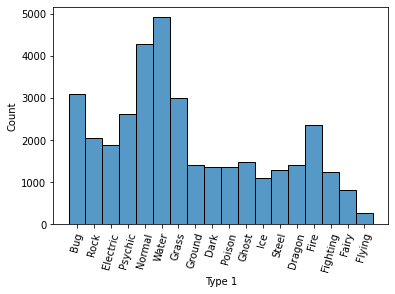

In [6]:
plot = sns.histplot(data = data, x = "Type 1")
plot.tick_params(axis='x', rotation=75)

3. Determine which of the features have missing values. How many missing values there are for each one?

In [7]:
"""
Here we can see that almos all features have missing values. 
As total of entries is 40000 and all features have <40000
"""
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 39087 to 15795
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               36006 non-null  object 
 1   Type 1             36026 non-null  object 
 2   Type 2             19465 non-null  object 
 3   HP                 35994 non-null  float64
 4   Attack             36103 non-null  float64
 5   Defense            35966 non-null  float64
 6   Sp. Atk            36080 non-null  float64
 7   Sp. Def            36018 non-null  float64
 8   Speed              36028 non-null  float64
 9   Generation         36007 non-null  float64
 10  Legendary          36019 non-null  object 
 11  Name__other        36037 non-null  object 
 12  Type 1__other      35990 non-null  object 
 13  Type 2__other      19406 non-null  object 
 14  HP__other          35895 non-null  float64
 15  Attack__other      36005 non-null  float64
 16  Defense__other    

4. Analize the distribution of the target column. Is it balanced?

In [8]:
"""
Yes it is!
"""
data["Wins"].value_counts()

False    21152
True     18848
Name: Wins, dtype: int64

## More visualitzation on the data

**Correlations**

<AxesSubplot:>

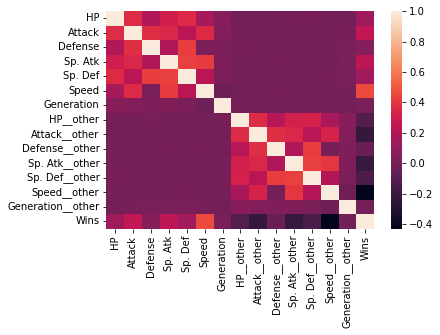

In [9]:
sns.heatmap(data=data.corr())

**Type relation with statistics**

Here we want to check if the Type have some influence in determined statistics in orther to do use it as an heuristic when filling null values:

In [10]:
type_1 = list(filter(lambda v: v==v, data["Type 1"].unique()))
type_2 = list(filter(lambda v: v==v, data["Type 2"].unique()))
type_1_other = list(filter(lambda v: v==v, data["Type 1__other"].unique()))
type_2_other = list(filter(lambda v: v==v, data["Type 2__other"].unique()))

In [11]:
type_list = list(set(type_1 + type_2 + type_1_other + type_2_other))   

In [12]:
pokemon = data[['Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']]
pokemon_other = data[['Name__other', 'Type 1__other', 'Type 2__other', 'HP__other', 'Attack__other', 'Defense__other', 'Sp. Atk__other', 'Sp. Def__other', 'Speed__other', 'Generation__other', 'Legendary__other']]
#Lets get this two Datasets Together
pokemon_other = pokemon_other.rename(columns={'Name__other' : 'Name', 
                                      'Type 1__other' : 'Type 1', 
                                      'Type 2__other' : 'Type 2', 
                                      'HP__other' : 'HP',
                                      'Attack__other' : 'Attack',
                                      'Defense__other' : 'Defense',
                                      'Sp. Atk__other' : 'Sp. Atk',
                                      'Sp. Def__other' : 'Sp. Def',
                                      'Speed__other' : 'Speed',
                                      'Generation__other' : 'Generation',
                                      'Legendary__other' : 'Legendary'
                                     })
pokemons = pandas.concat([pokemon, pokemon_other])

In [13]:
def split_by_type(dataset):
    type_classification = {}
    for ptype in type_list:
        type_classification[ptype] = dataset.loc[(dataset['Type 1'] == ptype) | (dataset['Type 2'] == ptype)]
    return type_classification

In [14]:
pokemons_by_type = split_by_type(pokemons)

I decided to use the median becouse there can be some outliers or bad data that make go the mean dont work as good as I expect. Also, the pokemon dataset can have some pokemons with really bad statistics and then a lot mor of decent statistics, but as we have some pokemons with so bad statistics the mean infeer that the type has bad statistics overall.

In [15]:
stats_median_by_type = {
    'HP' : [],
    'Attack' : [],
    'Defense' : [],
    'Sp. Atk' : [],
    'Sp. Def' : [],
    'Speed' : []
}
dic_median_by_type = {
    'HP' : {},
    'Attack' : {},
    'Defense' : {},
    'Sp. Atk' : {},
    'Sp. Def' : {},
    'Speed' : {}
}
for ptype, dataframe in pokemons_by_type.items():
    stats_median_by_type['HP'].append([ptype, dataframe['HP'].median()])
    dic_median_by_type['HP'][ptype] = dataframe['HP'].median()
    stats_median_by_type['Attack'].append([ptype, dataframe['Attack'].median()])
    dic_median_by_type['Attack'][ptype] = dataframe['Attack'].median()
    stats_median_by_type['Defense'].append([ptype, dataframe['Defense'].median()])
    dic_median_by_type['Defense'][ptype] = dataframe['Defense'].median()
    stats_median_by_type['Sp. Atk'].append([ptype, dataframe['Sp. Atk'].median()])
    dic_median_by_type['Sp. Atk'][ptype] = dataframe['Sp. Atk'].median()
    stats_median_by_type['Sp. Def'].append([ptype, dataframe['Sp. Def'].median()])
    dic_median_by_type['Sp. Def'][ptype] = dataframe['Sp. Def'].median()
    stats_median_by_type['Speed'].append([ptype, dataframe['Speed'].median()])
    dic_median_by_type['Speed'][ptype] = dataframe['Speed'].median()

In [16]:
statistics = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

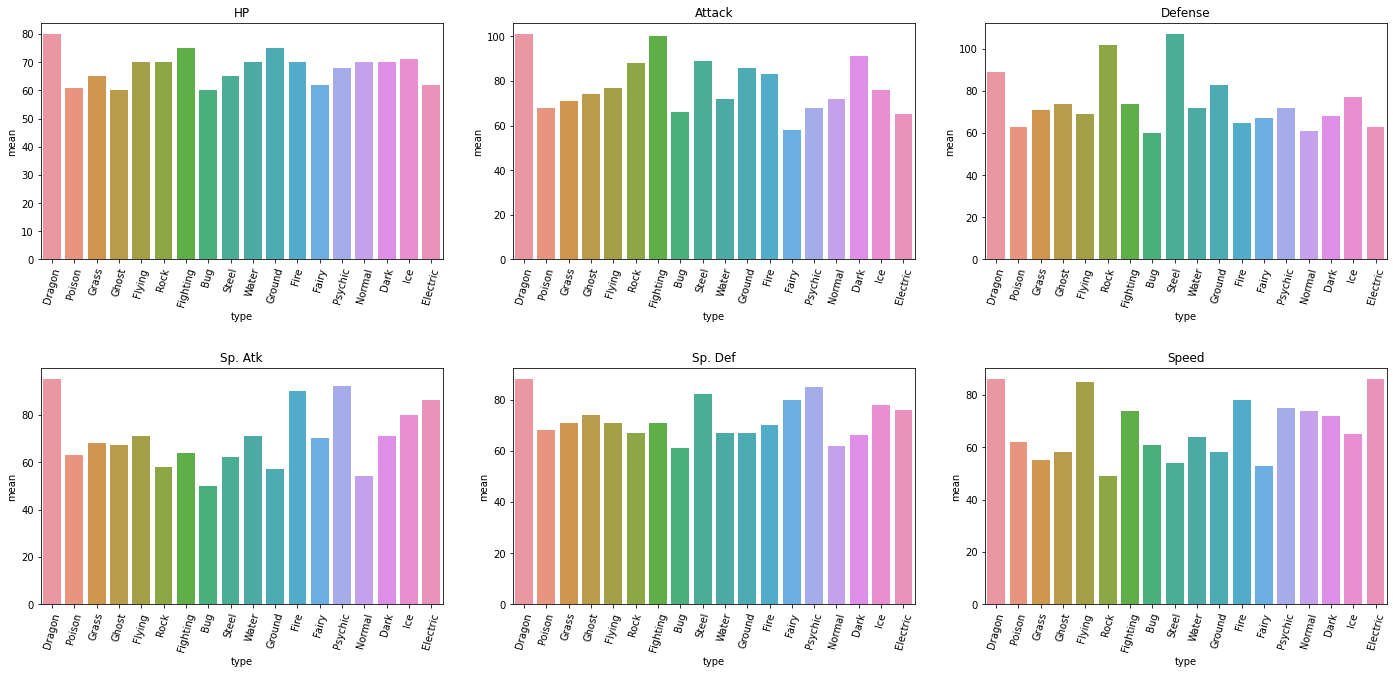

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
persist_mean_by_type = {}
for i,stat in enumerate(statistics):
    mean_by_type = pandas.DataFrame(stats_median_by_type[stat], columns=["type", "mean"])
    sns.barplot(data = mean_by_type, x = "type", y = "mean", ax=ax[math.floor(i/3)][i%3])
    ax[math.floor(i/3)][i%3].set_title(stat)
    ax[math.floor(i/3)][i%3].tick_params(axis='x', rotation=75)
    persist_mean_by_type[stat] = mean_by_type
fig.tight_layout(pad=3.0)

**Check nulls**

Rows with all nulls

In [18]:
def nans(df): return df[df.isnull().all(axis=1)]
len(nans(data))

0

Rows with at least 1 null

In [19]:
def nans(df): return df[df.isnull().any(axis=1)]
len(nans(data))

38939

In [20]:
def null_count(dataframe):
    count = []
    nulls = 1
    i = 0
    while nulls != 0:
        nulls = len([x for x in dataframe.isnull().sum(axis=1).tolist() if x > i])
        count.append([i, nulls])
        i += 1
    return count

In [21]:
null_count(data)

[[0, 38939],
 [1, 34037],
 [2, 24582],
 [3, 14004],
 [4, 6339],
 [5, 2265],
 [6, 700],
 [7, 174],
 [8, 34],
 [9, 8],
 [10, 1],
 [11, 1],
 [12, 0]]

**Check outliers for statistics**

As has been observed that each type has peculiarities in its statistics we should look for outliers for each type.

In [22]:
def plot_statistics_boxplots_by_type(ptype):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
    for i,stat in enumerate(statistics):
        sns.boxplot(data=pokemons_by_type[ptype], x=stat, ax=ax[math.floor(i/3)][i%3])
        ax[math.floor(i/3)][i%3].set_title(stat)
        ax[math.floor(i/3)][i%3].tick_params(axis='x', rotation=75)
    fig.tight_layout(pad=3.0)
    return fig

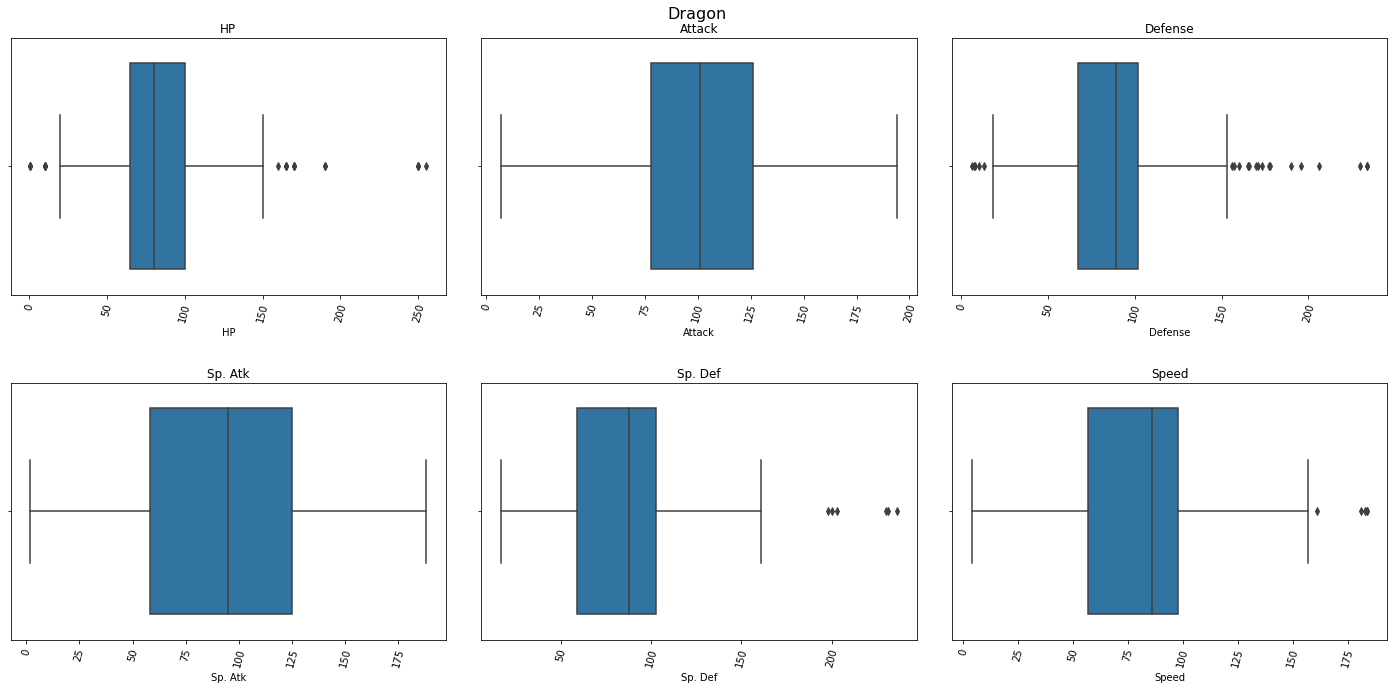

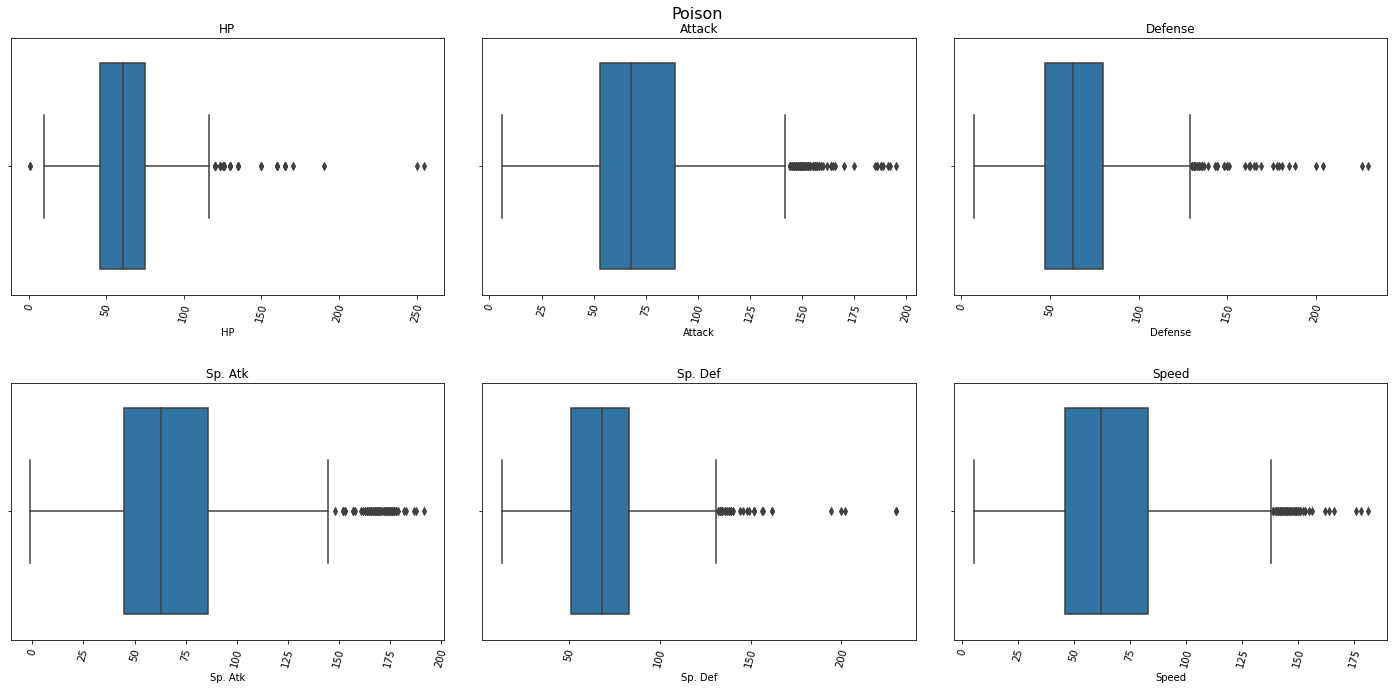

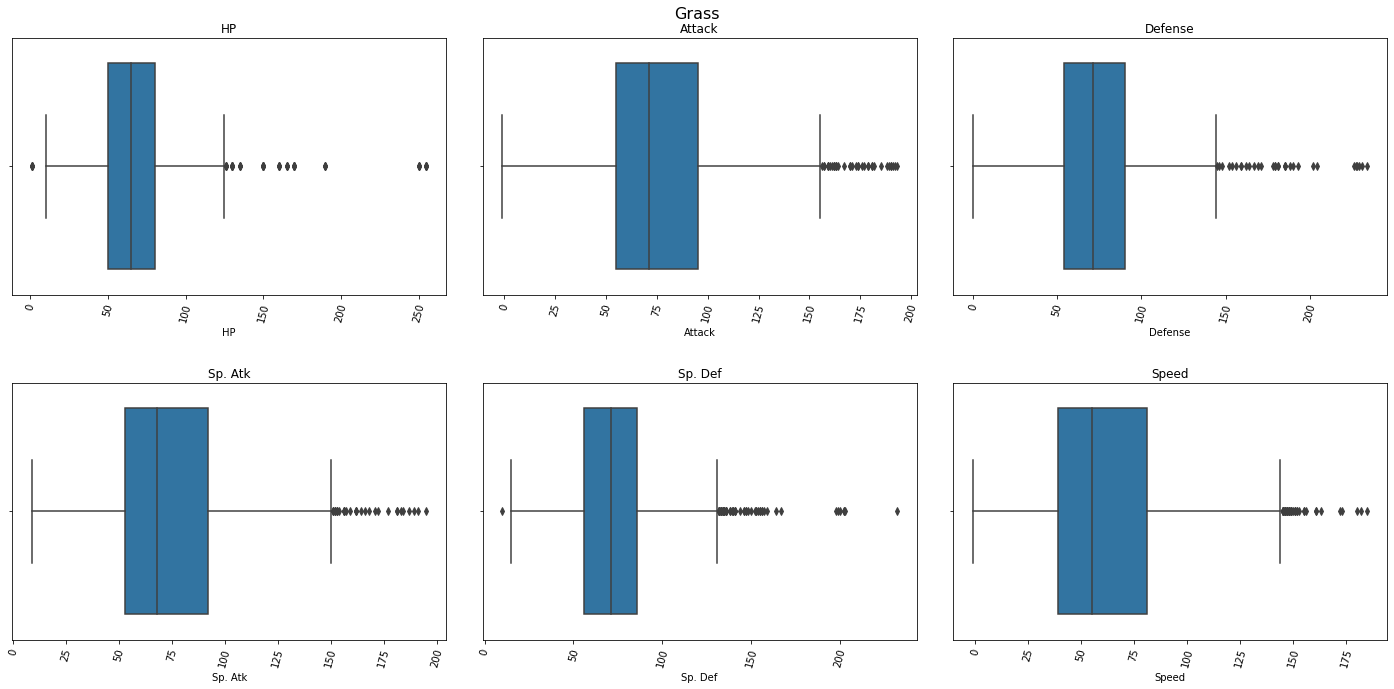

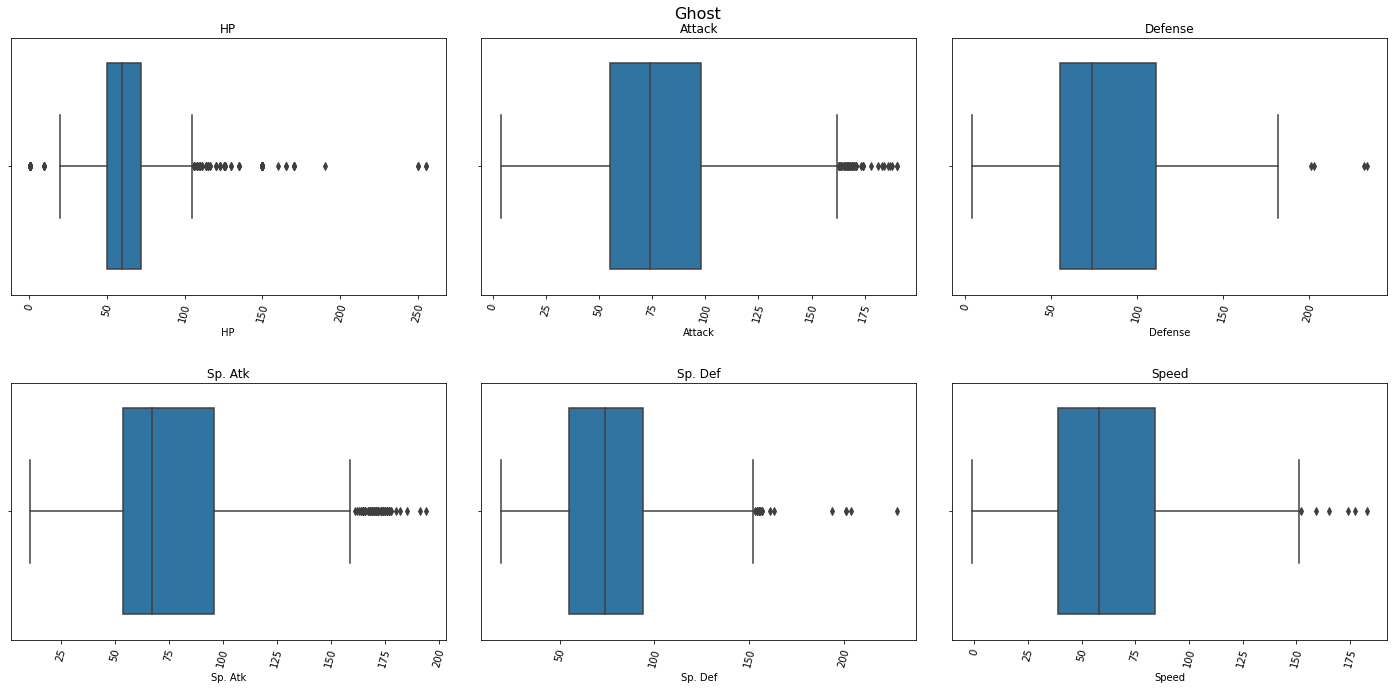

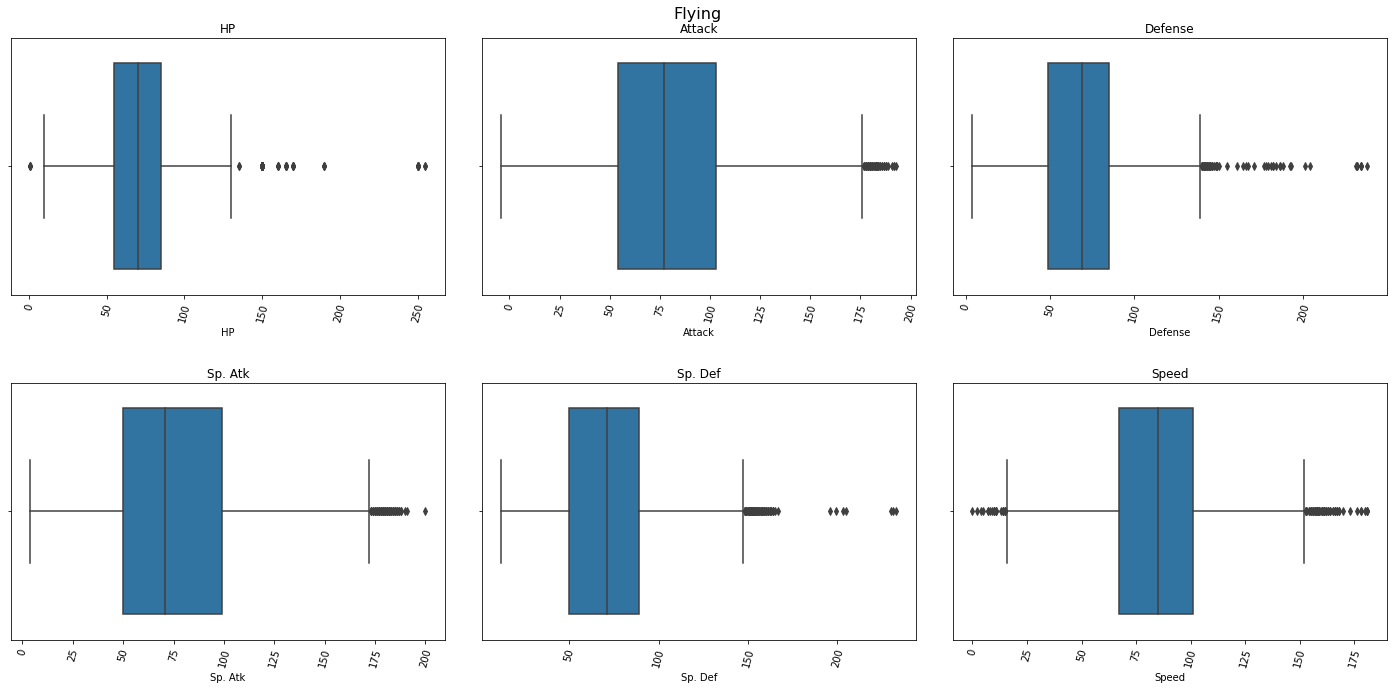

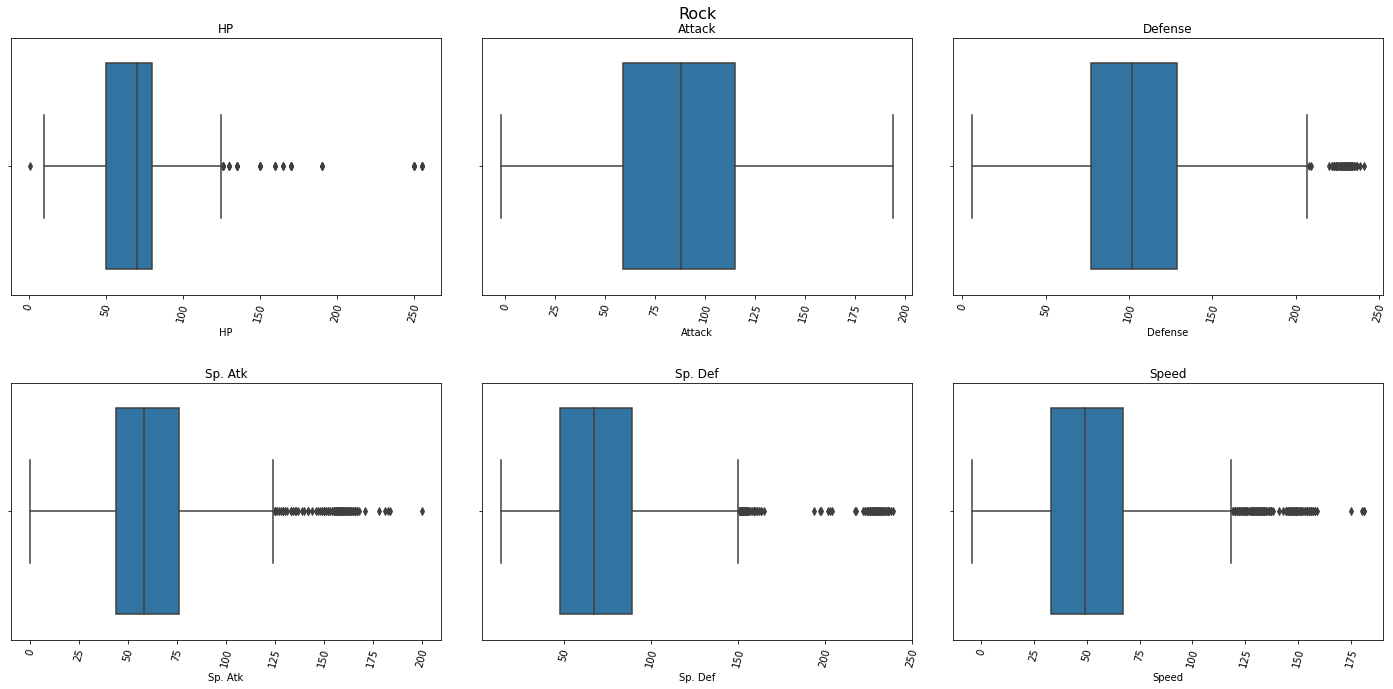

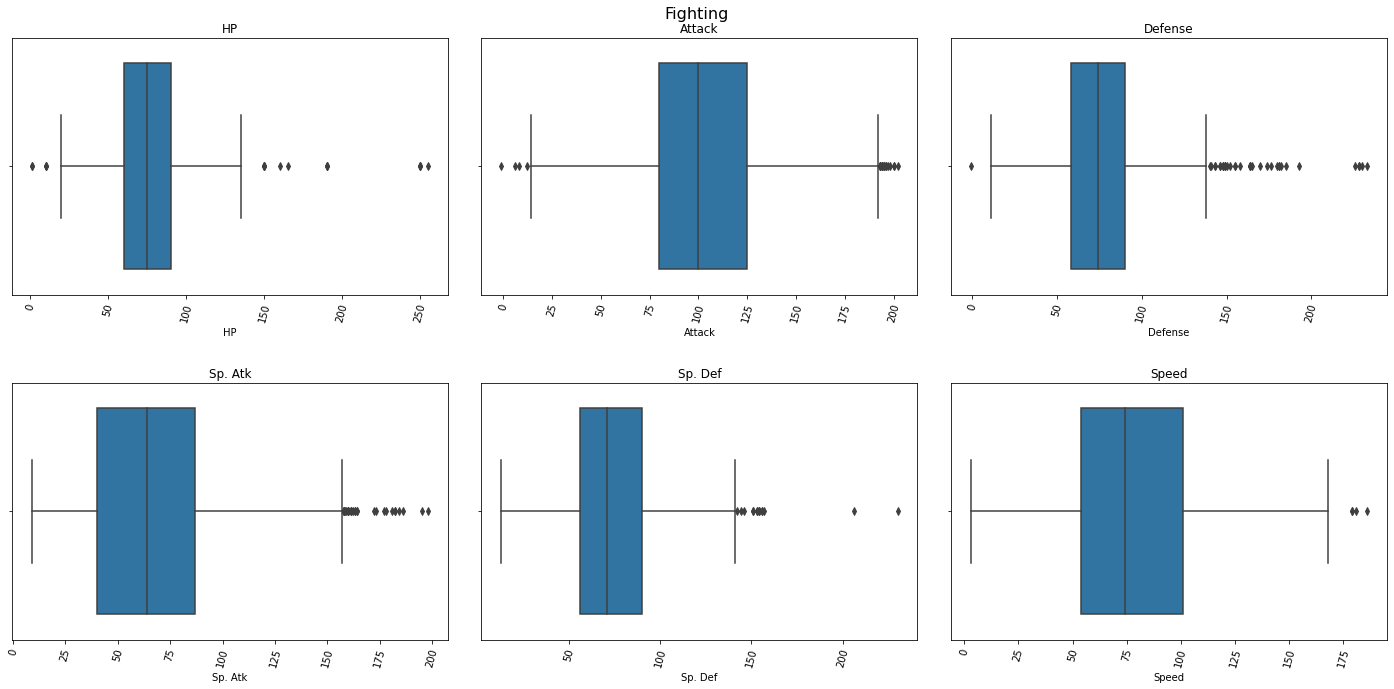

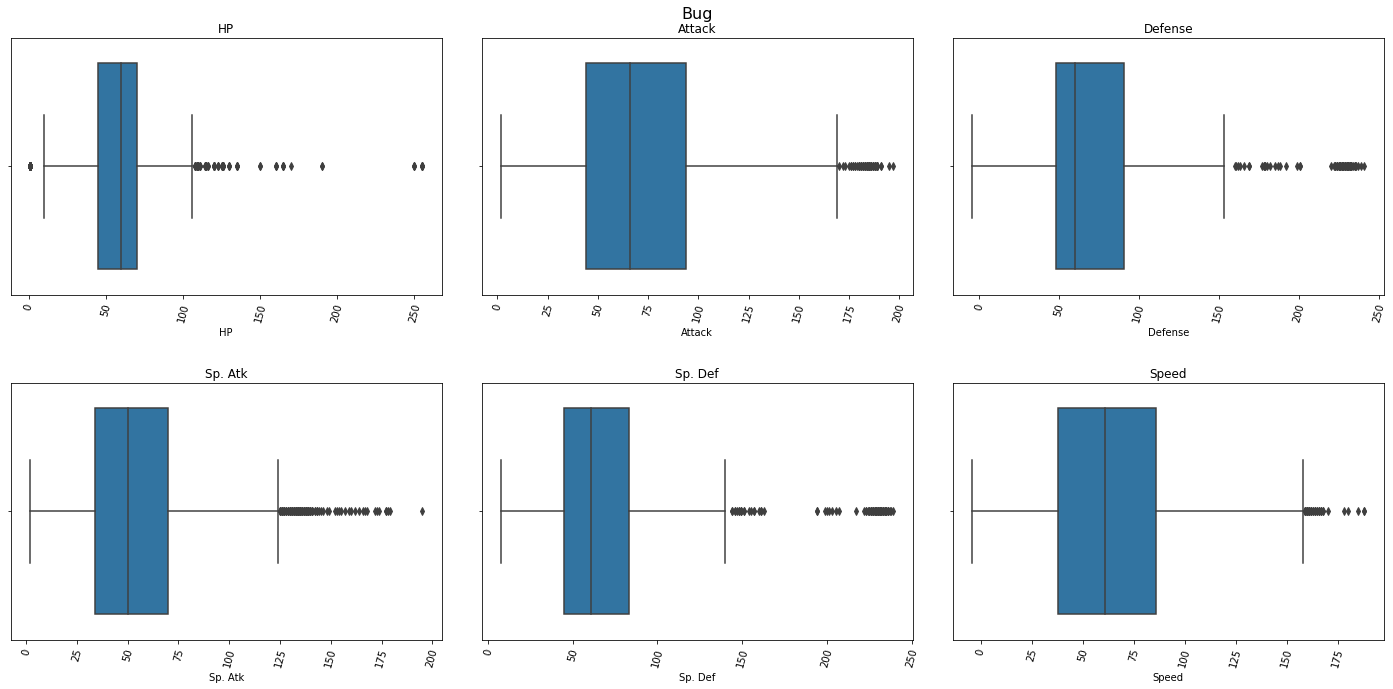

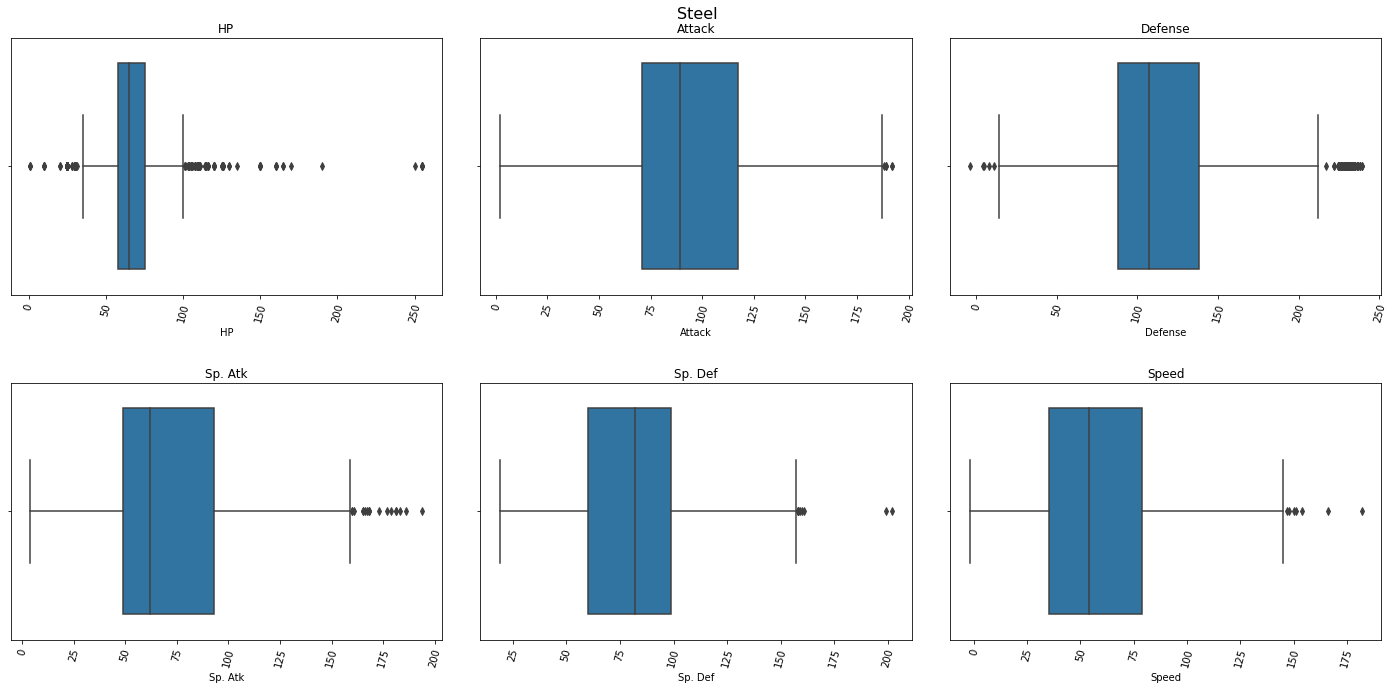

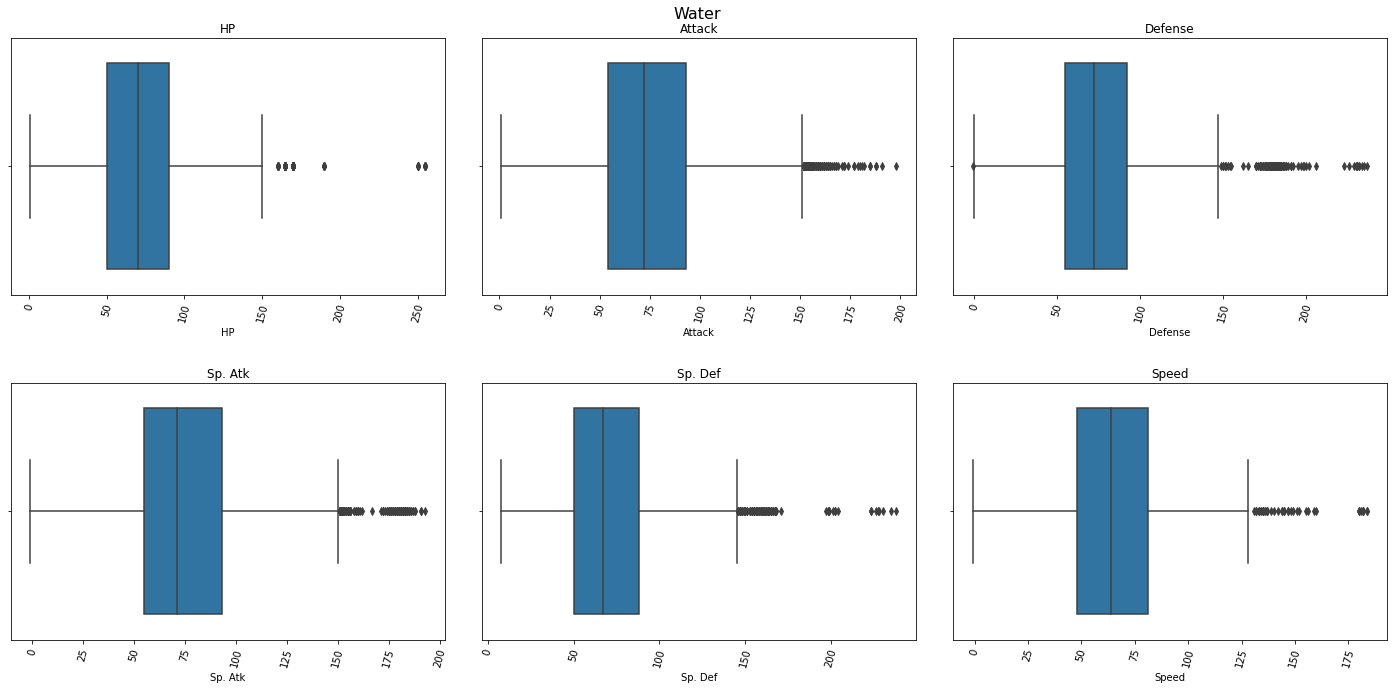

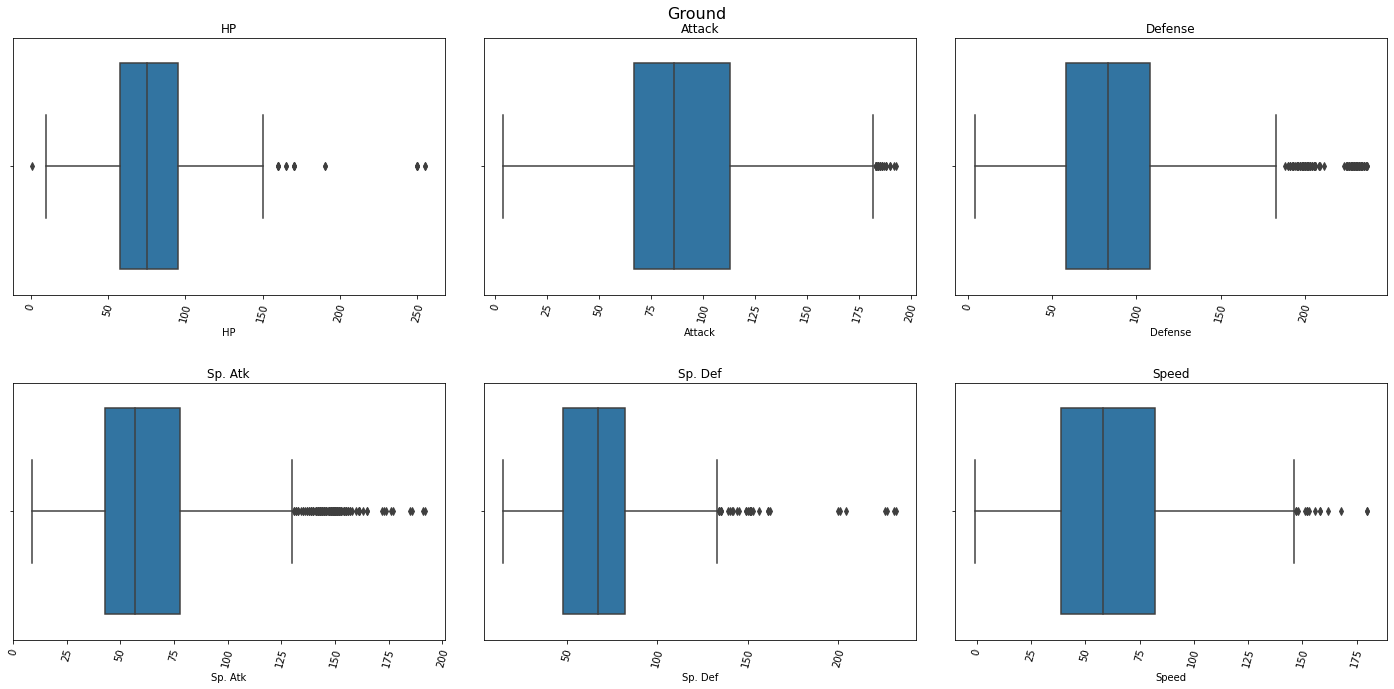

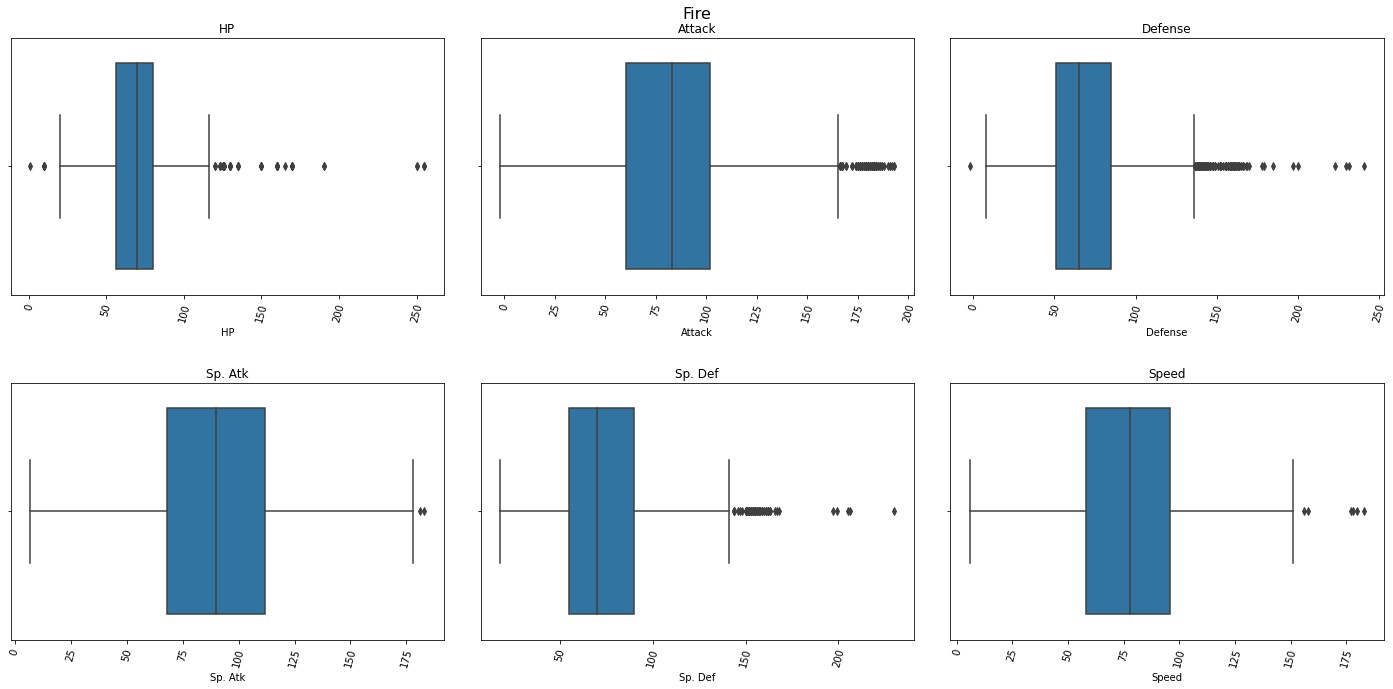

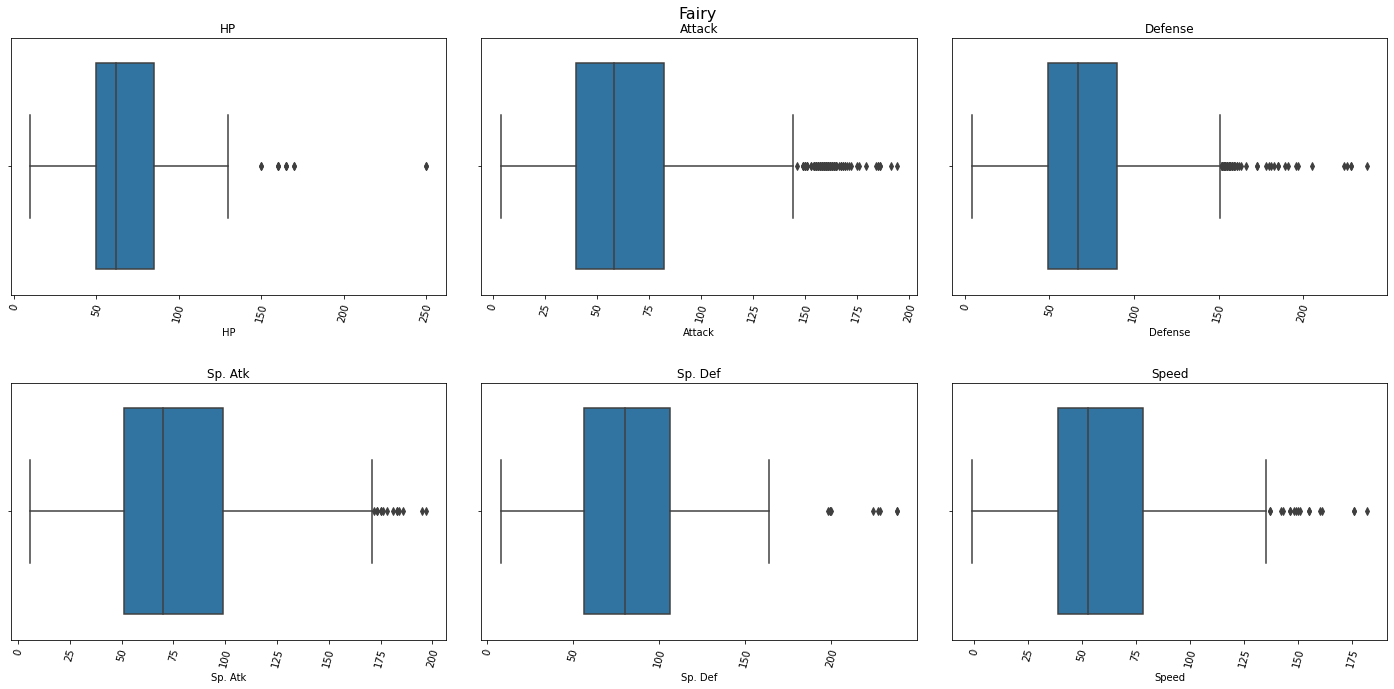

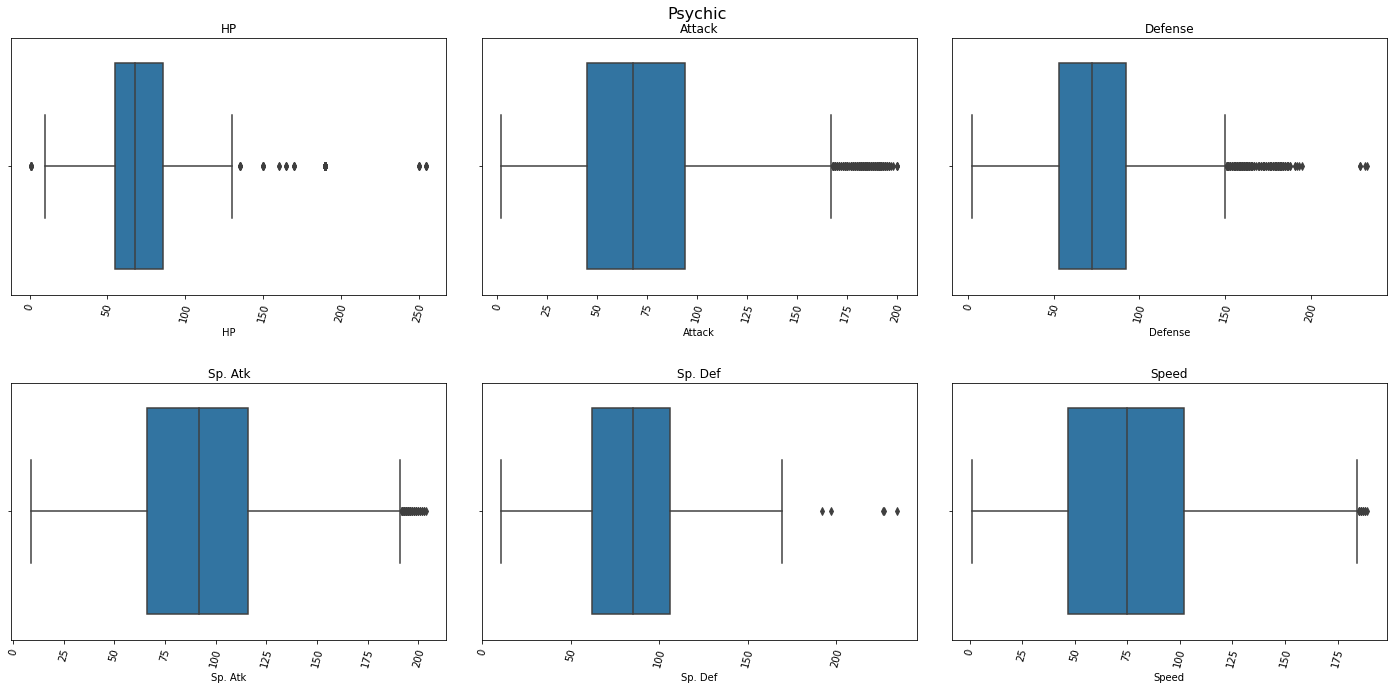

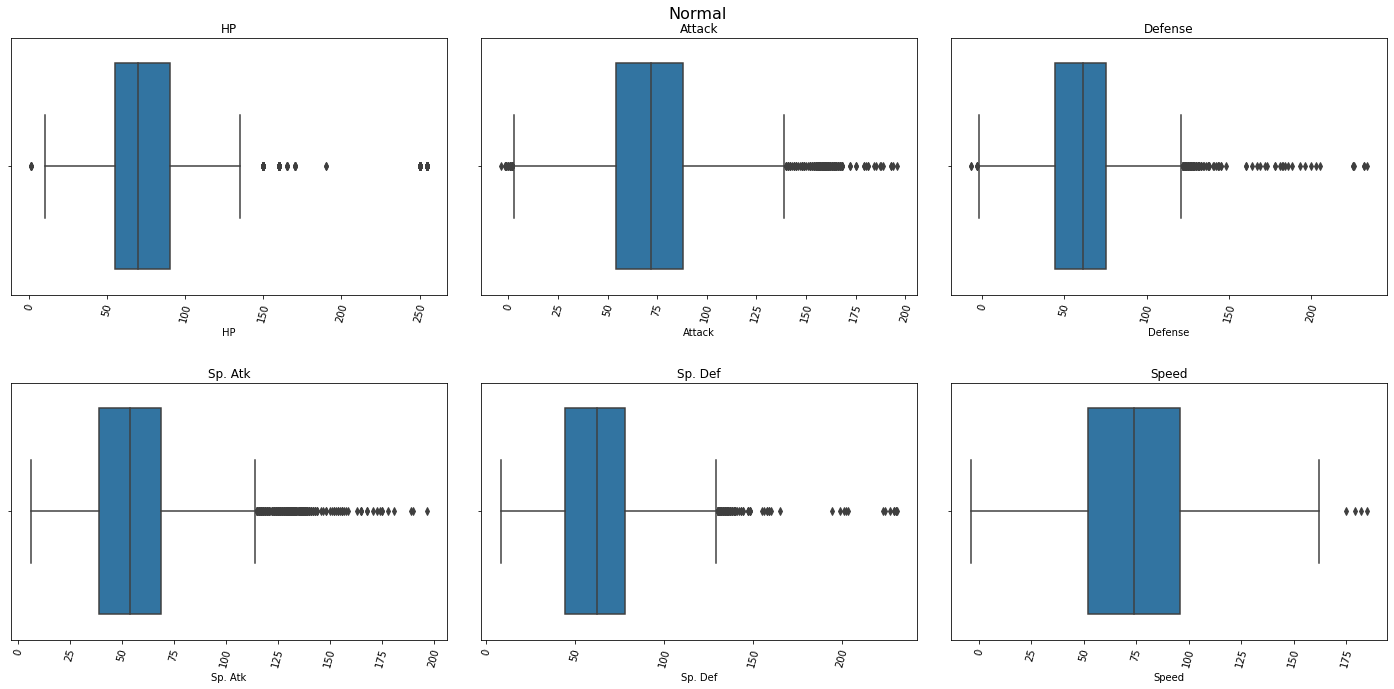

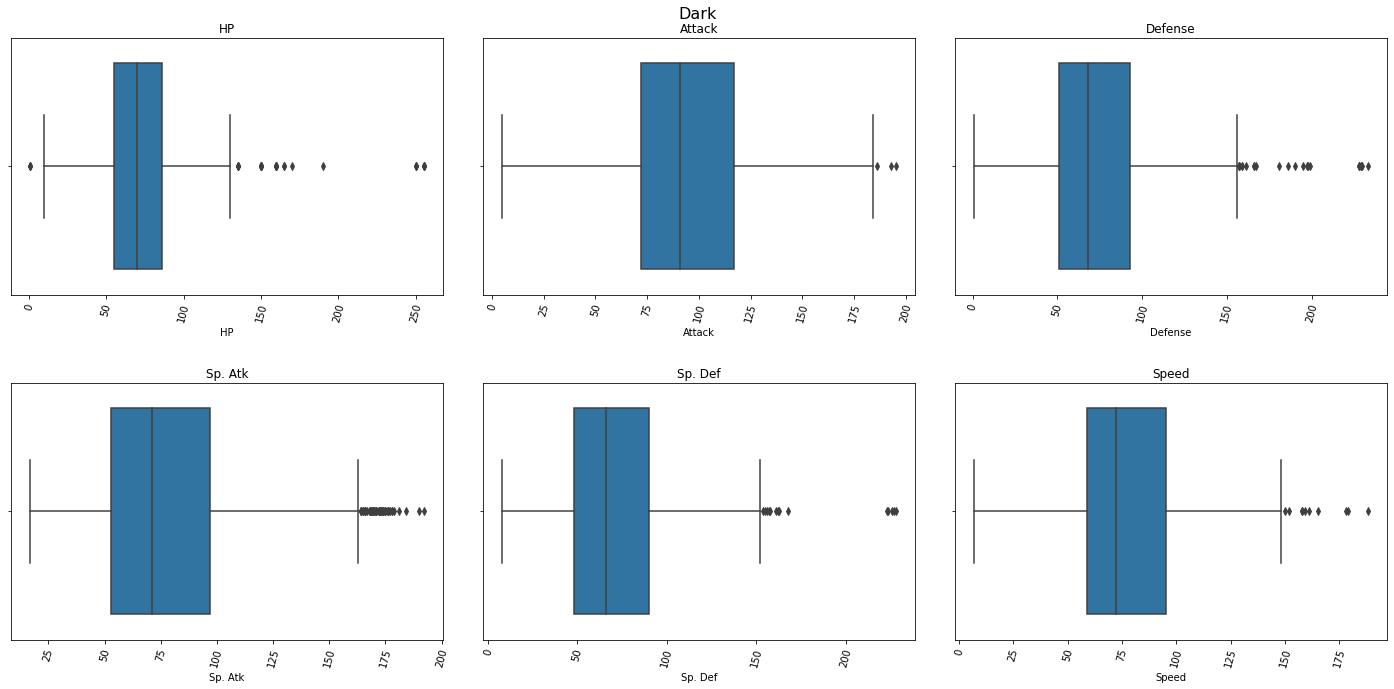

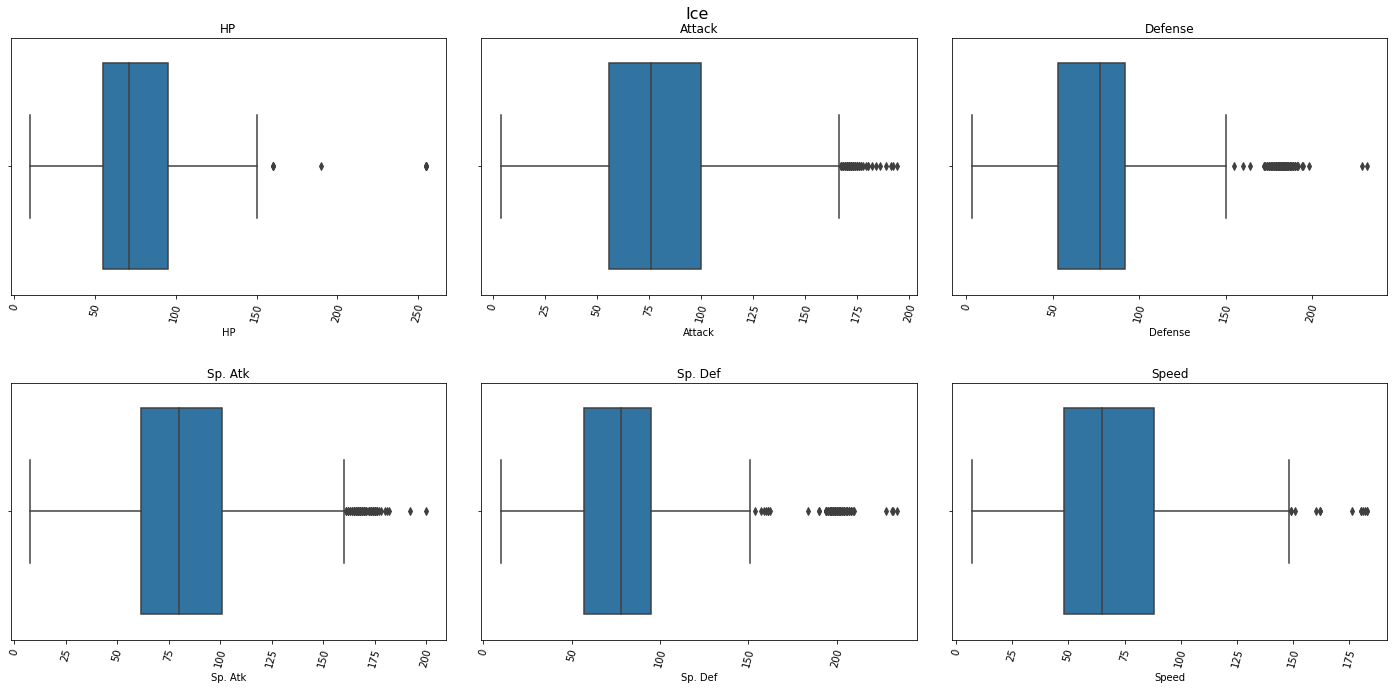

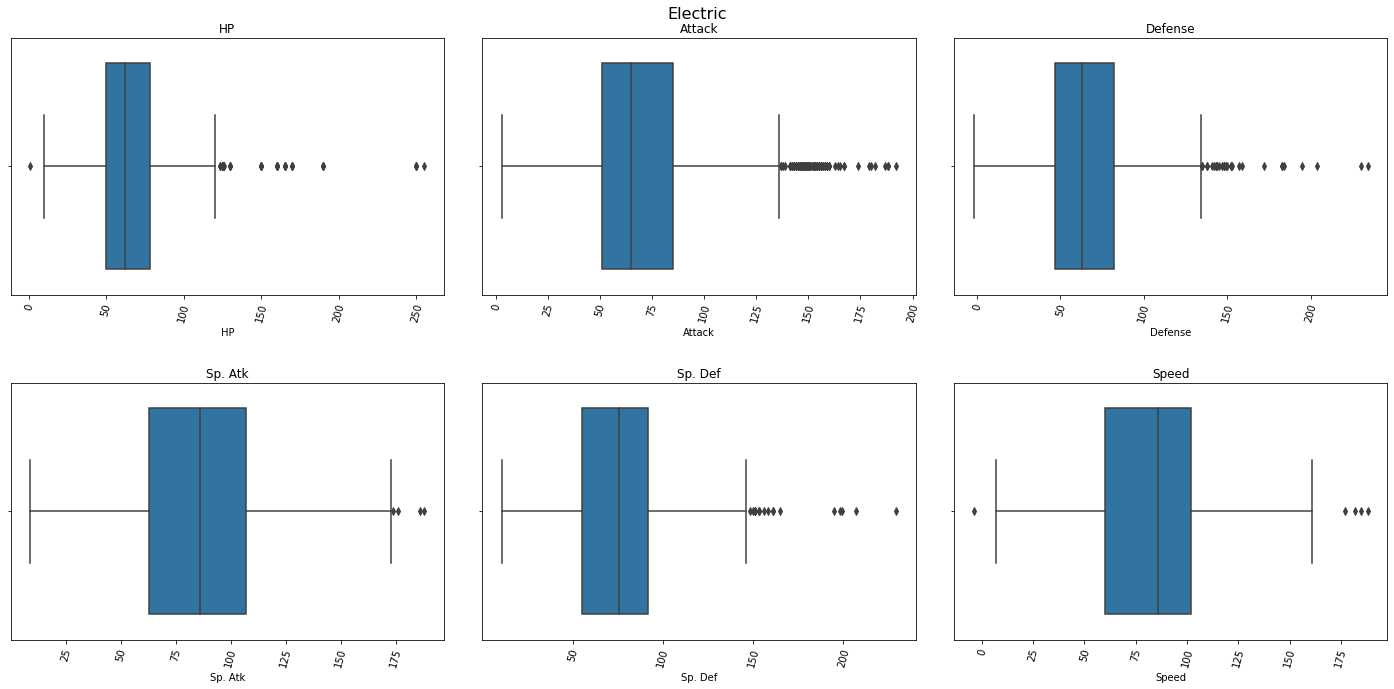

In [23]:
for ptype in type_list:
    plot_statistics_boxplots_by_type(ptype).suptitle(ptype, fontsize=16)


Some observations: 
- Seems that all the outlayers atempt to be in the right part of the dataset. This could be becouse there are pokemons that contain two different types, and for example a pokemon like Scarmory, that is steal flying and has a good velocity, is outlyer in terms of steal pokemon terms.
- Also, legendary pokemons for sure apear as outlyers of every single type.
- Seems that all the pokemons present in the dataset contain more or less the same level, due that ther are not outliers in thje bottom part of the graohics.
- Also, we can assume that the data does not contain that much noise in terms of fake numbers.

## Number of legendaries

In [24]:
len(pokemons[pokemons['Legendary'] == True])

6639

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

First I will delete the columns that I think that are useless:
- Legenday tags, becouse I think that it cames implicit in the statistics
- Generation Tag, it doesnt care the generation of the pokemon. It does not give any valuable information.
- Name, The name is usless also when we want to figure out wich pokemon wins a combat


I will try 2 things. As it has been seen that more or less each type has it's own characteristics, in a first instance I will try to feed a model without types, eventhough the type in pokemon allways has been an important thing. This is becouse maybe the type of the pokemons can be infered directly from the statistics, as each type has its own metrics.

After trying this i will try to encode the type and fit the model with the type encoded to see if the results are better

In [32]:
pdata_no_type = data.copy()
pdata = data.copy()
#pdata_no_type.drop(["Name", "Name__other", "Generation", "Generation__other", "Legendary", "Legendary__other", "Type 1", "Type 2", "Type 1__other", "Type 2__other"], axis = 1)
pdata = pdata.drop(["Name", "Name__other", "Generation", "Generation__other", "Legendary", "Legendary__other"], axis = 1)
pdata

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
39087,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,True
30893,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,True
45278,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,True
16398,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,False
13653,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,Water,NaN,55.0,NaN,107.0,NaN,79.0,56.0,True
44732,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,Normal,NaN,65.0,59.0,70.0,79.0,79.0,33.0,False
38158,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,Normal,NaN,104.0,91.0,61.0,97.0,117.0,68.0,True
860,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,Electric,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,True


I delete all the columns where the Type 1 and Type 1_other its null, as we are going to infeer the missing value from the median of each type statistics.

In [33]:
pdata = pdata.dropna(subset=['Type 1'] ,how='all')
pdata = pdata.dropna(subset=['Type 1__other'] ,how='all')

In [34]:
pdata

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1__other,Type 2__other,HP__other,Attack__other,Defense__other,Sp. Atk__other,Sp. Def__other,Speed__other,Wins
39087,Bug,NaN,50.0,72.0,39.0,39.0,42.0,55.0,Normal,NaN,50.0,53.0,43.0,47.0,27.0,40.0,True
30893,Rock,Water,70.0,NaN,125.0,113.0,78.0,NaN,Fire,NaN,65.0,64.0,NaN,49.0,41.0,39.0,True
45278,Electric,NaN,70.0,77.0,81.0,NaN,91.0,136.0,Poison,NaN,NaN,48.0,78.0,NaN,83.0,75.0,True
16398,Psychic,NaN,95.0,121.0,NaN,39.0,85.0,NaN,Normal,NaN,75.0,108.0,101.0,39.0,68.0,106.0,False
13653,Normal,Flying,45.0,36.0,58.0,37.0,76.0,56.0,Psychic,Fairy,40.0,46.0,68.0,108.0,123.0,86.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Grass,Fairy,60.0,63.0,122.0,79.0,103.0,118.0,Water,NaN,55.0,NaN,107.0,NaN,79.0,56.0,True
44732,Poison,Water,50.0,63.0,56.0,54.0,54.0,36.0,Normal,NaN,65.0,59.0,70.0,79.0,79.0,33.0,False
38158,Fairy,NaN,78.0,58.0,65.0,109.0,NaN,75.0,Normal,NaN,104.0,91.0,61.0,97.0,117.0,68.0,True
860,Electric,NaN,NaN,43.0,67.0,55.0,92.0,97.0,Electric,Dragon,50.0,70.0,101.0,112.0,97.0,83.0,True


Split the dataset

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(pdata, pdata["Wins"]):
    strat_train_set = pdata.iloc[train_index]
    strat_test_set = pdata.iloc[test_index]

In [37]:
strat_train_set["Wins"].value_counts()/len(strat_train_set)

False    0.527623
True     0.472377
Name: Wins, dtype: float64

In [38]:
strat_test_set["Wins"].value_counts()/len(strat_test_set)

False    0.527696
True     0.472304
Name: Wins, dtype: float64

Here we infeer the statistics that are null using the median of each statistic of each type. If a pookemon has two types, the mean of the median of the statistic of that types is gonna be used, in orther to do a balance of statistics from both types.

In [39]:
null_dataframe = pandas.isna(strat_train_set)

def get_stat_by_type(stat, i):
    if null_dataframe.loc[i, "Type 2"]:
        strat_train_set.loc[i, stat] = dic_median_by_type[stat][strat_train_set.loc[i, "Type 1"]]
    else:    
        strat_train_set.loc[i, stat] = (dic_median_by_type[stat][strat_train_set.loc[i, "Type 1"]] + dic_median_by_type[stat][strat_train_set.loc[i, "Type 2"]]) / 2

def get_stat_by_type_other(stat, i):
    stat_other = stat+"__other"
    if null_dataframe.loc[i, "Type 2__other"]:
        strat_train_set.loc[i, stat_other] = dic_median_by_type[stat][strat_train_set.loc[i, "Type 1__other"]]
    else:    
        strat_train_set.loc[i, stat_other] = (dic_median_by_type[stat][strat_train_set.loc[i, "Type 1__other"]] + dic_median_by_type[stat][strat_train_set.loc[i, "Type 2__other"]]) / 2

def fill_na_statistics(stat, i):
    stat_other = stat+"__other"
    if null_dataframe.loc[i, stat]:
        get_stat_by_type(stat, i)
    if null_dataframe.loc[i, stat_other]:
        get_stat_by_type_other(stat, i)

for i,row in strat_train_set.iterrows():
    fill_na_statistics("HP", i)
    fill_na_statistics("Attack", i)
    fill_na_statistics("Defense", i)
    fill_na_statistics("Sp. Atk", i)
    fill_na_statistics("Sp. Def", i)
    fill_na_statistics("Speed", i)

/home/quimpm/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [40]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25920 entries, 49071 to 21300
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type 1          25920 non-null  object 
 1   Type 2          12669 non-null  object 
 2   HP              25920 non-null  float64
 3   Attack          25920 non-null  float64
 4   Defense         25920 non-null  float64
 5   Sp. Atk         25920 non-null  float64
 6   Sp. Def         25920 non-null  float64
 7   Speed           25920 non-null  float64
 8   Type 1__other   25920 non-null  object 
 9   Type 2__other   12563 non-null  object 
 10  HP__other       25920 non-null  float64
 11  Attack__other   25920 non-null  float64
 12  Defense__other  25920 non-null  float64
 13  Sp. Atk__other  25920 non-null  float64
 14  Sp. Def__other  25920 non-null  float64
 15  Speed__other    25920 non-null  float64
 16  Wins            25920 non-null  bool   
dtypes: bool(1), float64(12), ob

We delete the types, becouse, as I explained previously, this first models are going to be trained without the type becouse it's belived that the statistics are representative of the types.

In [41]:
strat_train_set = strat_train_set.drop(["Type 1", "Type 2", "Type 1__other", "Type 2__other"], axis = 1)
strat_test_set = strat_test_set.drop(["Type 1", "Type 2", "Type 1__other", "Type 2__other"], axis = 1)

In [42]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25920 entries, 49071 to 21300
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              25920 non-null  float64
 1   Attack          25920 non-null  float64
 2   Defense         25920 non-null  float64
 3   Sp. Atk         25920 non-null  float64
 4   Sp. Def         25920 non-null  float64
 5   Speed           25920 non-null  float64
 6   HP__other       25920 non-null  float64
 7   Attack__other   25920 non-null  float64
 8   Defense__other  25920 non-null  float64
 9   Sp. Atk__other  25920 non-null  float64
 10  Sp. Def__other  25920 non-null  float64
 11  Speed__other    25920 non-null  float64
 12  Wins            25920 non-null  bool   
dtypes: bool(1), float64(12)
memory usage: 3.6 MB


In [43]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6481 entries, 6378 to 33497
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              5848 non-null   float64
 1   Attack          5894 non-null   float64
 2   Defense         5828 non-null   float64
 3   Sp. Atk         5852 non-null   float64
 4   Sp. Def         5800 non-null   float64
 5   Speed           5819 non-null   float64
 6   HP__other       5801 non-null   float64
 7   Attack__other   5832 non-null   float64
 8   Defense__other  5802 non-null   float64
 9   Sp. Atk__other  5764 non-null   float64
 10  Sp. Def__other  5806 non-null   float64
 11  Speed__other    5822 non-null   float64
 12  Wins            6481 non-null   bool   
dtypes: bool(1), float64(12)
memory usage: 664.6 KB


In [47]:
strat_test_set_droped_nas = strat_test_set.dropna(how="any", axis=0)
strat_test_set_droped_nas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 479 to 15050
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HP              1818 non-null   float64
 1   Attack          1818 non-null   float64
 2   Defense         1818 non-null   float64
 3   Sp. Atk         1818 non-null   float64
 4   Sp. Def         1818 non-null   float64
 5   Speed           1818 non-null   float64
 6   HP__other       1818 non-null   float64
 7   Attack__other   1818 non-null   float64
 8   Defense__other  1818 non-null   float64
 9   Sp. Atk__other  1818 non-null   float64
 10  Sp. Def__other  1818 non-null   float64
 11  Speed__other    1818 non-null   float64
 12  Wins            1818 non-null   bool   
dtypes: bool(1), float64(12)
memory usage: 186.4 KB


In [48]:
strat_test_set_droped_nas["Wins"].value_counts()/len(strat_test_set_droped_nas)

False    0.541254
True     0.458746
Name: Wins, dtype: float64

HUUUUUUUH NOT BAD PROPORTIONS, but just 1818 :( Let's try anyway.

With this done, we have our first preprocessing fase completed

## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [58]:
X_train = strat_train_set.drop(["Wins"], axis = 1)
y_train = strat_train_set["Wins"]
X_test = strat_test_set_droped_nas.drop(["Wins"], axis = 1)
y_test = strat_test_set_droped_nas["Wins"]

In [59]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [60]:
print("Train score:", model.score(X_train, y_train))

Train score: 0.9999614197530864


In [61]:
y_test_pred = model.predict(X_test)
y_test_pred

array([False,  True,  True, ..., False,  True, False])

In [62]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.8888888888888888

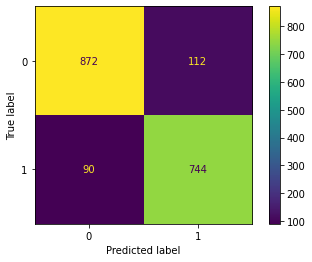

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

In [ ]:
# Your code here...

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [ ]:
# Your code here...